# Imports

In [1]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Task 1

Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

## Solution

### Explanation and assumptions

**Explanation**

For this task, we have to retrieve the information in 2 separate steps.

The first step is to retrieve the data (name of university, rank, country and region) using a simple GET query on a file. We used the Postman extension with the interceptor in order to find this file. The file contains a list of the 1000 best ranked universities sorted by rank. This file contains data in the JSON format.

The second step is to retrieve the number of faculty members and the number of students (international and total) for each university by following the details page found in the JSON data. When reaching the details page, we can simply parse the HTML and retrieve the needed information.

**Assumptions**

Some universities do not have statistics for the number of students and the number of faculty members so we store NaN for those features.

We also store the score of the university even if not asked in order to use it in the next steps

### Data retrieving

In [2]:
# Constants

TOP_UNIVERSITIES_BASE = 'https://www.topuniversities.com'
TOP_UNIVERSITIES_RANKING = TOP_UNIVERSITIES_BASE + '/sites/default/files/qs-rankings-data/357051.txt'
column_names = ['name', 'rank_top', 'country', 'region', 'score']

# mapping between div class names in the HTML and the column name in the dataframe
names_map = {
    'total faculty': 'faculty_tot',
    'inter faculty': 'faculty_int',
    'total student': 'student_tot', 
    'total inter': 'student_int'
}

In [3]:
ranking = requests.get(TOP_UNIVERSITIES_RANKING)
top_200 = ranking.json()['data'][:200]

In [4]:
# Creates an empty dataframe with the desired columns
universities_top = pd.DataFrame(columns = (column_names + list(names_map.values())))

# Utilitary function to get the statistics information needed in the details page
def get_details_info(div_name):
    div = soup.find('div', class_=div_name)
    if div:
        return int(div
            .find('div', class_='number')
            .text
            .replace("\n", "")
            .replace(",", "")
            .strip())
    else:
        return float('NaN')

for university in top_200:
    row = {
        'name': university['title'],
        'rank_top': university['rank_display'],
        'country': university['country'],
        'region': university['region'],
        'score': university['score']
    }
    
    # For each university, we visit its detail page and retrieve the remanining statistics
    details_page_url = TOP_UNIVERSITIES_BASE + university['url']
    r = requests.get(details_page_url)
    soup = BeautifulSoup(r.text,'html.parser')
    
    for div_class, column_name in names_map.items():
        row[column_name] = get_details_info(div_class)
    
    universities_top = universities_top.append(row, ignore_index=True)

In [5]:
universities_top.head()

,name,rank_top,country,region,score,faculty_tot,faculty_int,student_tot,student_int
0,Massachusetts Institute of Technology (MIT),1,United States,North America,100,2982,1679,11067,3717
1,Stanford University,2,United States,North America,98.7,4285,2042,15878,3611
2,Harvard University,3,United States,North America,98.4,4350,1311,22429,5266
3,California Institute of Technology (Caltech),4,United States,North America,97.7,953,350,2255,647
4,University of Cambridge,5,United Kingdom,Europe,95.6,5490,2278,18770,6699


### 1) Which are the best universities in term of

We first define a little utilitary function to plot bar plots

In [26]:
def custom_bar_plot(x, y, data, title):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(title, fontsize=15, fontweight='bold')
    sns.barplot(x=x, y=y, data=data)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)

**(a) ratio between faculty members and students**

Here we just need to compute the ratio into a new column and sort by that column. We also drop the columns with NaN's because it means that we don't have that information

**Plotting this information in bar plots does not make sense as there are too many universities, so we decided to plot only the top 10 universities for this metric (as told by the TAs)**

We notice that the ranking of a university is not directly related to the number of staff members it has.

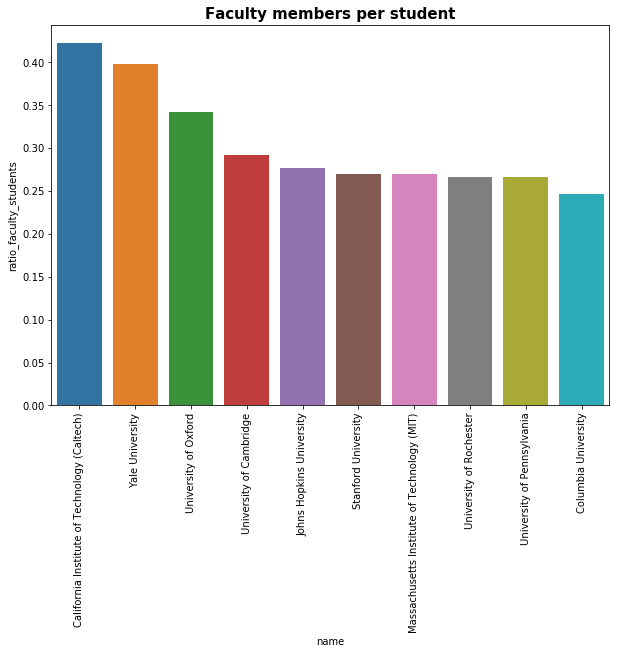

In [27]:
def ratio_faculty_students(df, columns):
    df['ratio_faculty_students'] = df['faculty_tot'] / df['student_tot']
    return df[columns].dropna()

data = ratio_faculty_students(universities_top, ['name', 'ratio_faculty_students']).sort_values('ratio_faculty_students', ascending=False)
custom_bar_plot('name', 'ratio_faculty_students', data[:10], 'Faculty members per student')

**(b) ratio of international students?**

Same here, we plot only the top 10 universities as there are too many.

We notice that London universities have many international students and that EPFL is the second one in the world! This is surprising for an engineering school as one might think that political science universities in Geneva would have more international students.

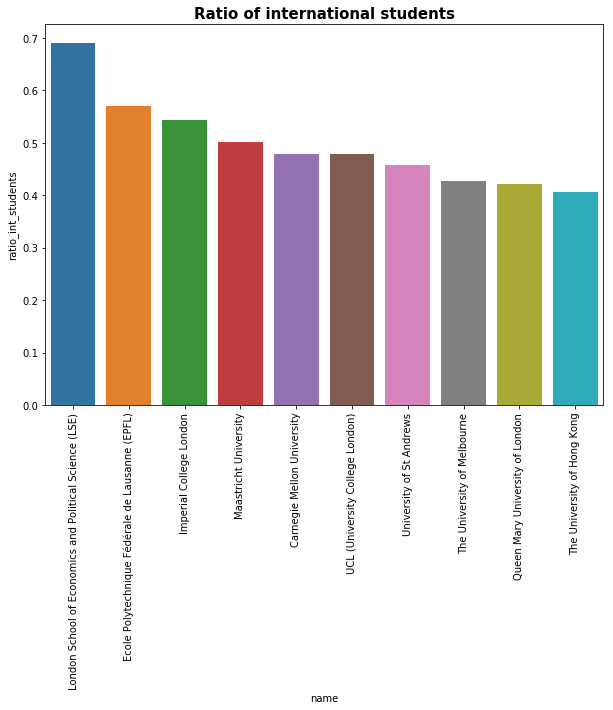

In [28]:
def ratio_int(df, columns):
    df['ratio_int_students'] = df['student_int'] / df['student_tot']
    return df[columns].dropna()

data = ratio_int(universities_top, ['name', 'ratio_int_students']).sort_values('ratio_int_students', ascending=False)
custom_bar_plot('name', 'ratio_int_students', data[:10], 'Ratio of international students')

### Answer the previous question aggregating the data by

**c) country**

Ratio of faculty members and students

In [29]:
universities_grouped_country = universities_top[['country', 'faculty_tot', 'student_tot', 'student_int']].groupby(['country'], as_index=False).sum()

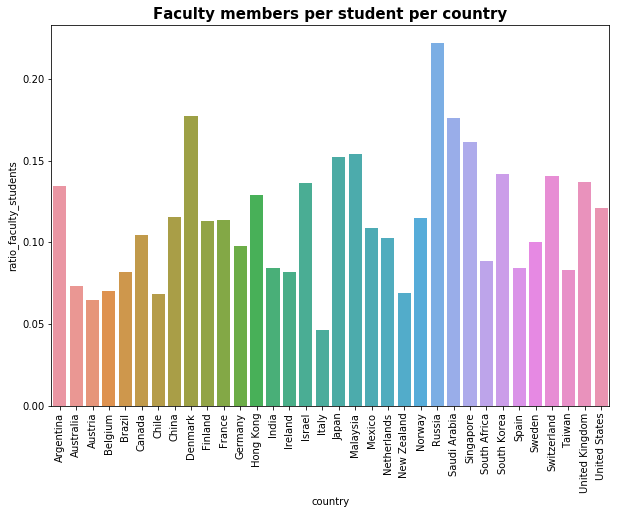

In [30]:
data = ratio_faculty_students(universities_grouped_country, ['country', 'ratio_faculty_students'])
custom_bar_plot('country', 'ratio_faculty_students', data, 'Faculty members per student per country')

The country with the most faculty members per student is Russia and the country with the less is Italy.

Ratio of international students

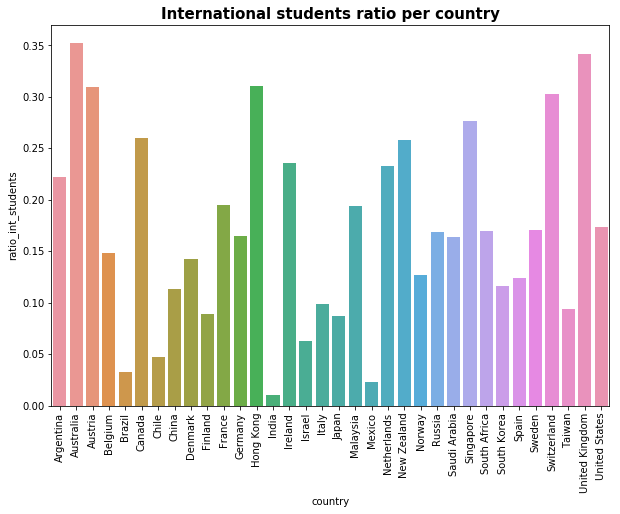

In [31]:
data = ratio_int(universities_grouped_country, ['country', 'ratio_int_students'])
custom_bar_plot('country', 'ratio_int_students', data, 'International students ratio per country')

India and Mexico have almost no international students while Australia is the country with the most.

**d) region**

Ratio of faculty members and students

In [32]:
universities_grouped_region = universities_top[['region', 'faculty_tot', 'student_tot', 'student_int']].groupby(['region'], as_index=False).sum()

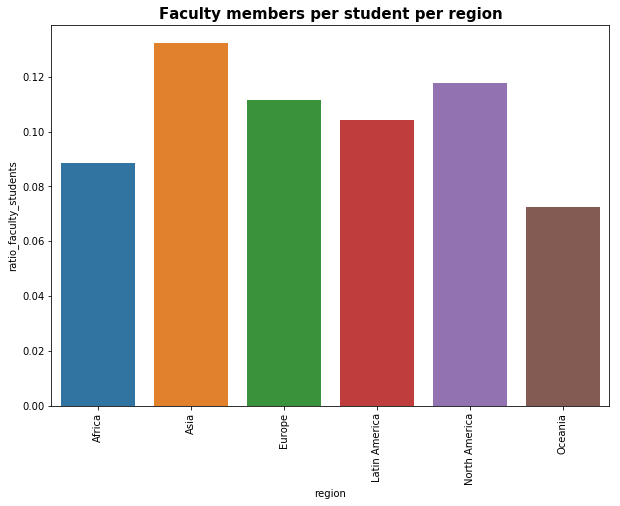

In [33]:
data = ratio_faculty_students(universities_grouped_region, ['region', 'ratio_faculty_students'])
custom_bar_plot('region', 'ratio_faculty_students', data, 'Faculty members per student per region')

As seen in the previous plot, asian universities have more staff members than other regions.

Ratio of international students

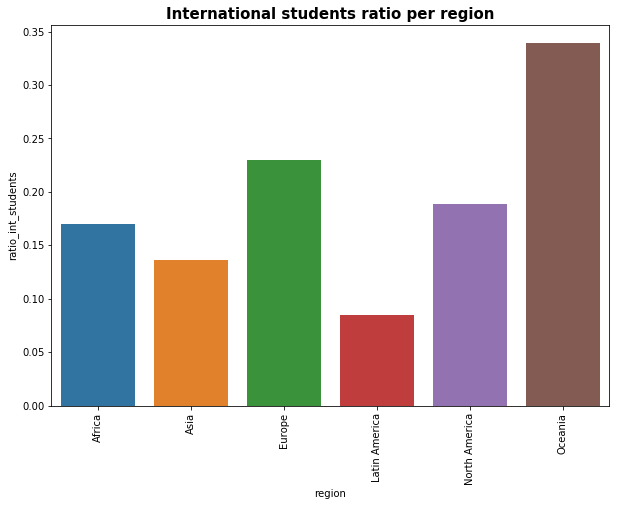

In [35]:
data = ratio_int(universities_grouped_region, ['region', 'ratio_int_students'])
custom_bar_plot('region', 'ratio_int_students', data, 'International students ratio per region')

Here we see that Oceania is the region with most international students because Australia was the country with the most international students and was one of the only countries in the top 200 being from Oceania.
So we can consider this 

## Task 2

Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

## Solution

### Explanation and assumptions

**Explanation**

For this task, we can retrieve the information in one step.

We retrieve the data using a simple GET query on a file. We used the Postman extension with the interceptor in order to find the URL of this file. The file contains the list of the universities sorted by rank. This file contains data in the JSON format.

From it we parse the name of university, rank, country, score, total faculty members, total number of student and percentage of international student. 

We use the first dataframe to fetch the region of a university and if no region can be found we will use the country as its own region. We do this because statistics of unknown region is meaningless.

We assume that the faculty members are the people who work for the students. So we retrieve the ratio of student per staff members and compute the total faculty members using this ratio and the total number of students. 

The number of international students is computed using the percentage retrieved on the website and the total number of students. 

We also ceil any value that we found since it is meaningless to have a non integer number of people.

## Code

In [ ]:
# Constants
PERCENT_FORMAT = "%.1f%%"
TIMES_BASE = 'https://www.timeshighereducation.com'
TIMES_RANKING = TIMES_BASE + '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
column_names = ['name', 'rank_times', 'country', 'region', 'score']
names_map = {
    'total faculty':'faculty_tot',
    'total student':'student_tot', 
    'total inter':'student_int'
}

In [ ]:
ranking = requests.get(TIMES_RANKING)
top_200 = ranking.json()['data'][:200]

In [ ]:
universities_times = pd.DataFrame(columns = (column_names + list(names_map.values())))

# Retrieve the regions of a country from the first Dataframe
def get_region(country):
    # Get rows where country is the same and filter to have only the region
    res = universities_top[universities_top['country']==country]['region']
    
    # Check that there is a result
    if len(res):
        region = res.iloc[0]
        return region
    else:
        return country

def to_int(value):
    return int(value.replace(",","").replace('%',""))

for university in top_200:
    row = {
        'name': university['name'],
        'rank_times': university['rank'],
        'country': university['location'],
        'region' : get_region(university['location'].strip()),
        'score': university['scores_overall'],
        'faculty_tot': np.ceil(to_int(university['stats_number_students']) / float(university['stats_student_staff_ratio'])),   
        'student_tot': to_int(university['stats_number_students']),
        'student_int': np.ceil(to_int(university['stats_number_students']) * (to_int(university['stats_pc_intl_students']) / 100)),   
    }
        
    universities_times = universities_times.append(row, ignore_index=True)

universities_times = universities_times.set_index(['name'])
universities_times['student_tot'] = universities_times['student_tot'].astype(int)

In [ ]:
universities_times.head(10)

#### a) ratio between faculty members and students

##### Explanation

We simply compute the ratio of total faculty members over the total number of students with the value we retrieved


In [ ]:
# Compute the ratio
universities_times['fac/stud'] = universities_times['faculty_tot'] / universities_times['student_tot']

# Convert it to float
universities_times['fac/stud'] = universities_times['fac/stud'].astype(float)

# Remove unwanted columns
fac_stud_ratio = universities_times[['fac/stud','country','region']]

# Sort on the ratio
fac_stud_ratio = fac_stud_ratio.sort_values(['fac/stud'],ascending=False)


show = fac_stud_ratio.copy()

# Show result with a meaningful string
show['fac/stud'] = show['fac/stud'].apply(lambda x : PERCENT_FORMAT % (x*100))
show.head(10)

##### Results

Universities of the United State has 7 out of 10 places in the top 10

#### b) ratio of international students

##### Explanation

Same here we compute the ratio of international student over the total number of student with the value we retrieved

In [ ]:
# Compute ratio
universities_times['int/stud'] = universities_times['student_int'] / universities_times['student_tot']

# Convert it to float
universities_times['int/stud'] = universities_times['int/stud'].astype(float)

# Remove unwanted columns
int_total_student = universities_times[['int/stud','country','region']]

# Sort on the ratio
int_total_student = int_total_student.sort_values(['int/stud'],ascending=False)

show = int_total_student.copy()

# Show result with a meaningful string
show['int/stud'] = show['int/stud'].apply(lambda x : PERCENT_FORMAT % (x*100))
show.head(10)

##### Results

The universities with the largest ratio of international student are the one located in Capitals and large cities. Here the United Kingdom has 5 out of 10 places in the top universities according to this ratio.

#### c)  
##### Explanation

To Aggregate we will fisrt sum all the student and inteernational student by Country and them compute the ratio. This way we will not give the same weight to smaller universities compared to larger ones.

##### 1) ratio between faculty members and students aggregated by country

In [ ]:
times_uni_grouped_country = universities_times[['country', 'faculty_tot', 'student_tot', 'student_int']].groupby(['country'], as_index=False).sum()

In [ ]:
data = ratio_faculty_students(times_uni_grouped_country, ['country', 'ratio_faculty_students'])
custom_bar_plot('country', 'ratio_faculty_students', data, 'Faculty members per student per country')

##### Results

When aggrating by country the results show that the first ones are not necessarily the ones with the best ranking on the site

##### 2) ratio of international students aggregated by country

In [ ]:
data = ratio_int(times_uni_grouped_country, ['country', 'ratio_int_students'])
custom_bar_plot('country', 'ratio_int_students', data, 'International students ratio per country')

##### Results

Even if the United States is a large and leading country, US universities are devanced by smaller countries like Luxembourg, Hong Kong, Singapore and New Zealand.

#### d) 
##### Explanation

Again we will fist sum all the student and international student of a region and then compute the ratio for the same reason as before.

##### 1) ratio between faculty members and students aggregated by region

In [ ]:
times_uni_grouped_region = universities_times[['region', 'faculty_tot', 'student_tot', 'student_int']].groupby(['region'], as_index=False).sum()

In [ ]:
data = ratio_faculty_students(universities_grouped_region, ['region', 'ratio_faculty_students'])
custom_bar_plot('region', 'ratio_faculty_students', data, 'Faculty members per student per region')

##### Results

Asia take the lead of the ranking when it comes to Faculty members per student.

##### 2) ratio of international students aggregated by region##### Results

In [ ]:
data = ratio_int(universities_grouped_region, ['region', 'ratio_int_students'])
custom_bar_plot('region', 'ratio_int_students', data, 'International students ratio per region')

##### Results

